In [104]:
# dataframe opertations - pandas
import pandas as pd
import numpy as np
import time 
# plotting data - matplotlib
from matplotlib import pyplot as plt
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [105]:
health = pd.read_csv('../output/cut-data.csv',
    usecols=['dates','occupancy'], index_col='dates', parse_dates=True)
health
print(health.index.dtype)
health_resampled = health.resample('M').mean()
print(health_resampled.index.freq)


datetime64[ns]
<MonthEnd>


In [106]:
print(health.shape)
print(health.head())

(700, 1)
            occupancy
dates                
2017-05-01        139
2017-05-02        135
2017-05-03        133
2017-05-04        133
2017-05-05        135


<Axes: title={'center': 'occupancy Data'}, xlabel='dates'>

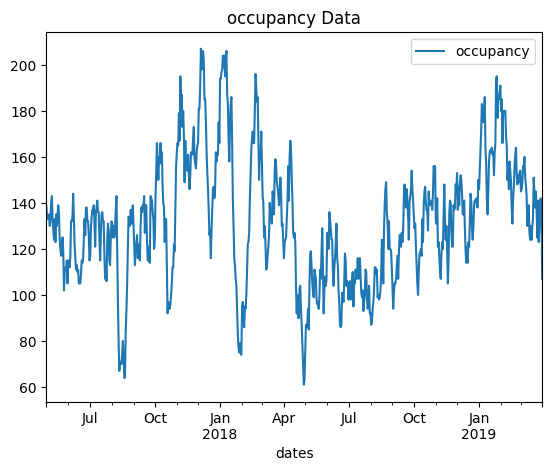

In [107]:

health[['occupancy']].plot(title='occupancy Data')

In [108]:
decompose_result = seasonal_decompose(health['occupancy'],model='multiplicative')

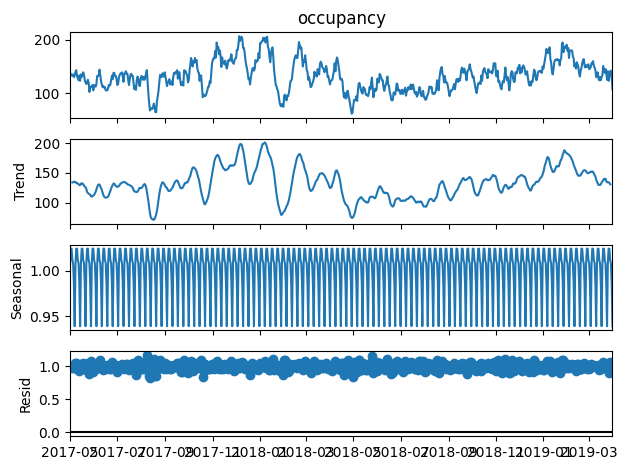

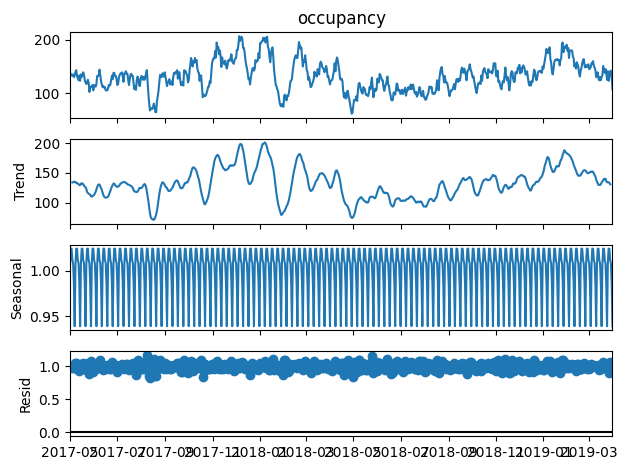

In [109]:
decompose_result.plot()

In [110]:
# Set the frequency of the date time index as Monthly start as indicated by the data
health.index.freq = 'D'
# Set the value of Alpha and define m (Time Period)
m = 12
alpha = 1/(2*m)

<Axes: title={'center': 'Holt Winters Single Exponential Smoothing'}, xlabel='dates'>

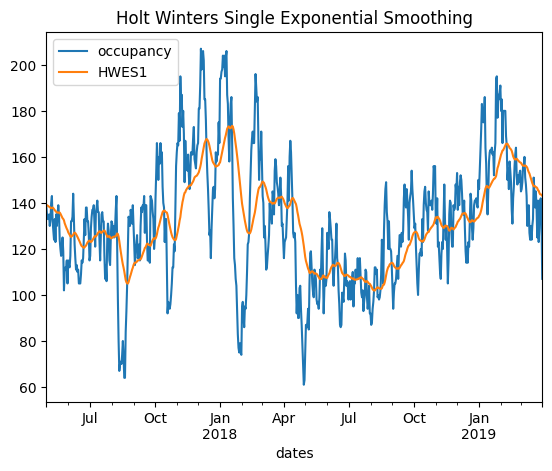

In [111]:
health['HWES1'] = SimpleExpSmoothing(health['occupancy']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
health[['occupancy','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

<Axes: title={'center': 'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='dates'>

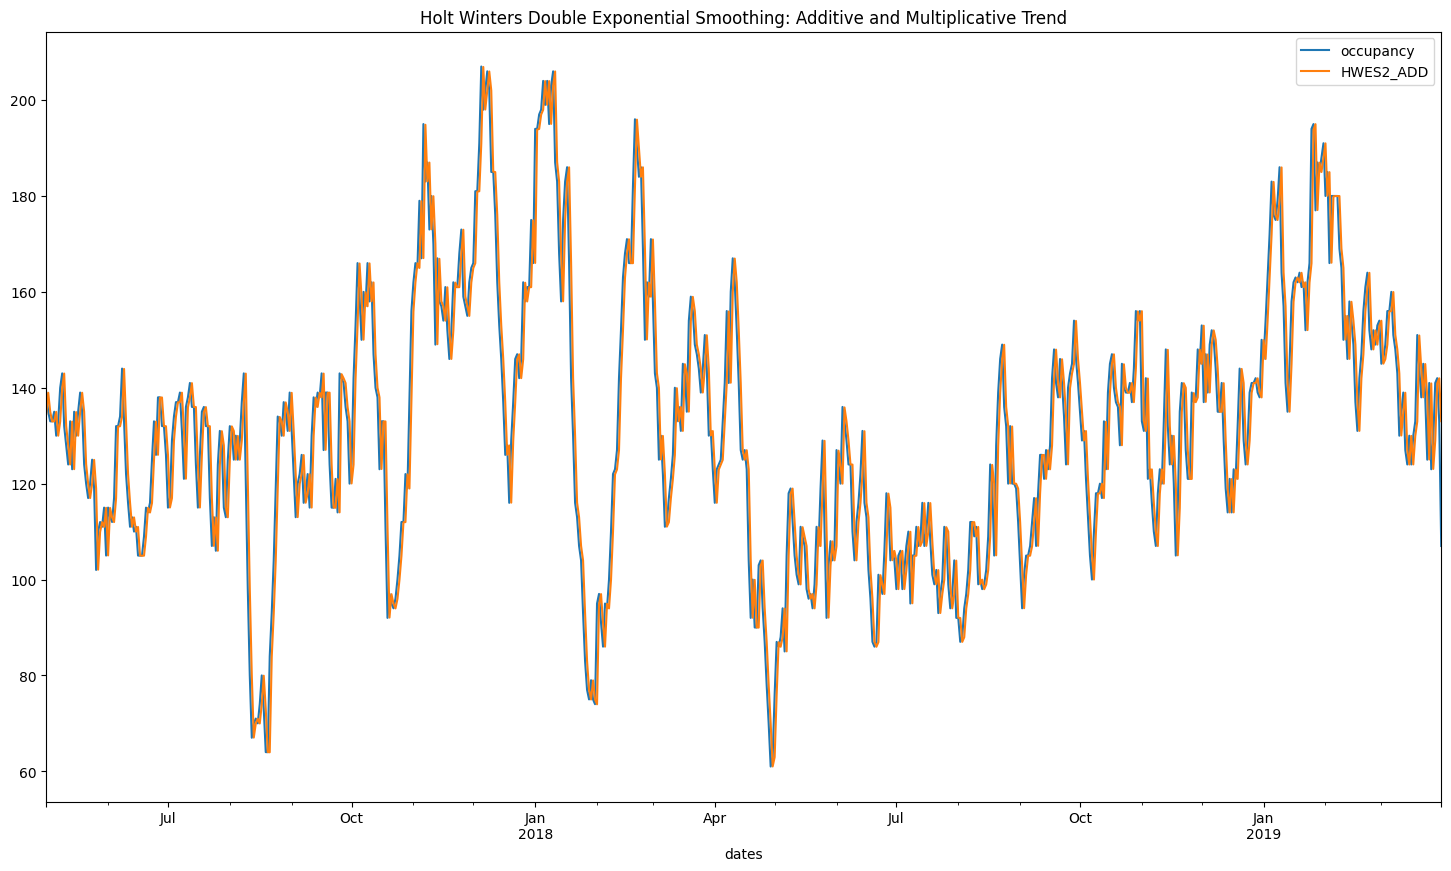

In [112]:
health['HWES2_ADD'] = ExponentialSmoothing(health['occupancy'],trend='add').fit().fittedvalues
health['HWES2_MUL'] = ExponentialSmoothing(health['occupancy'],trend='mul').fit()
health[['occupancy','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend',figsize=(18,10))

c:\Users\nguye\anaconda3\envs\py311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<Axes: title={'center': 'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='dates'>

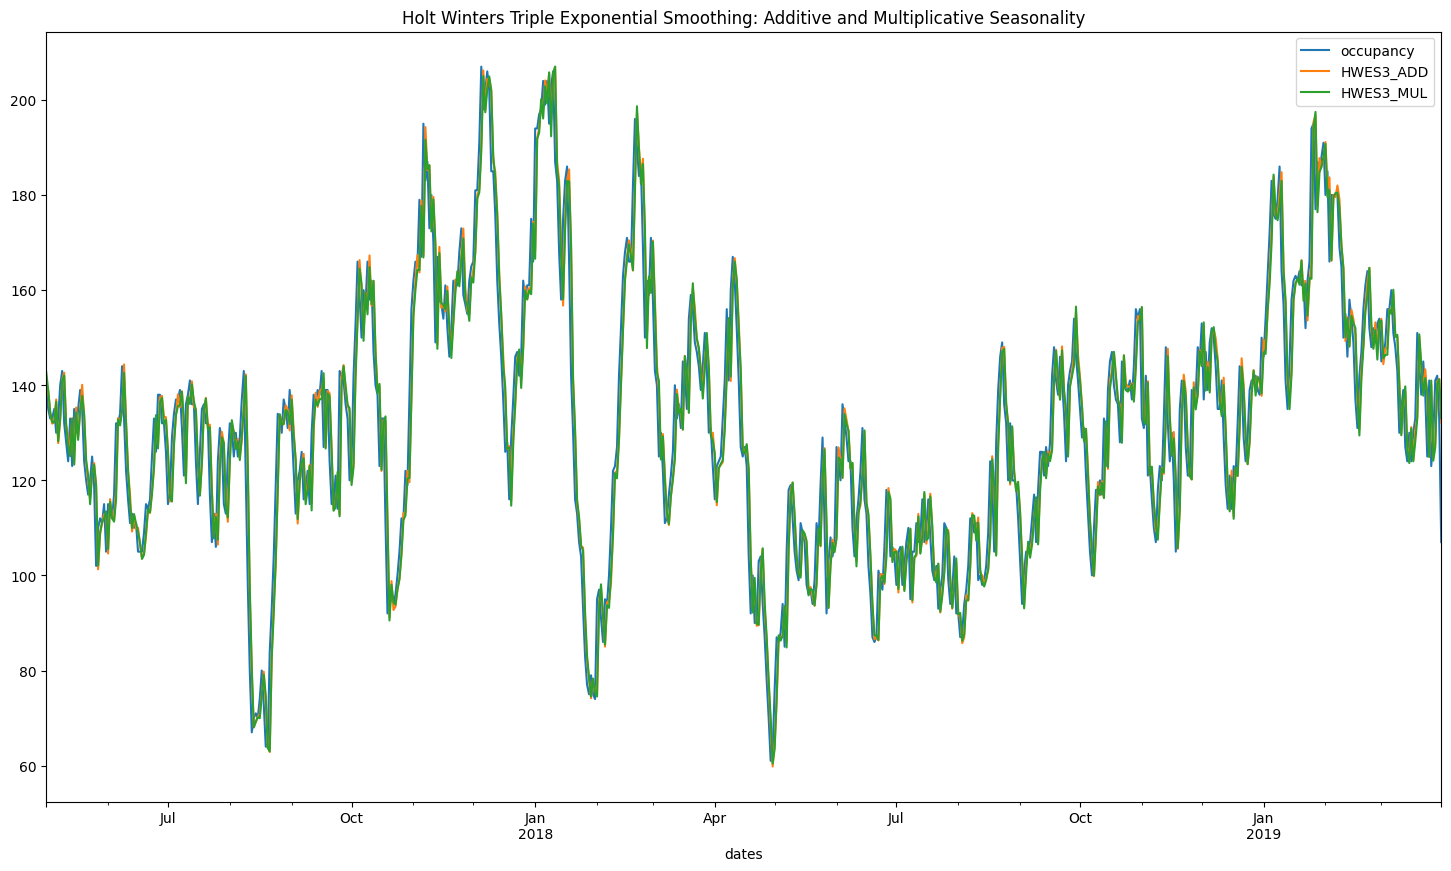

In [113]:
health['HWES3_ADD'] = ExponentialSmoothing(health['occupancy'],trend='add',seasonal='add',seasonal_periods=24).fit().fittedvalues
health['HWES3_MUL'] = ExponentialSmoothing(health['occupancy'],trend='mul',seasonal='mul',seasonal_periods=24).fit().fittedvalues
health[['occupancy','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality',figsize=(18,10))

In [114]:
health = pd.read_csv('../output/cut-data.csv',
    usecols=['dates','occupancy'], index_col='dates', parse_dates=True)
health.index.freq = 'D'
target_days = 30
holt_params = {
    'trend': 'mul', 
    'damped_trend': False,
    'seasonal': 'mul', 
    'seasonal_periods': 60, 
    'initialization_method': 
    'estimated'}
#train and test
train_health = health[0:len(health)-target_days]
test_health = health[len(health)-target_days:len(health)]

Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

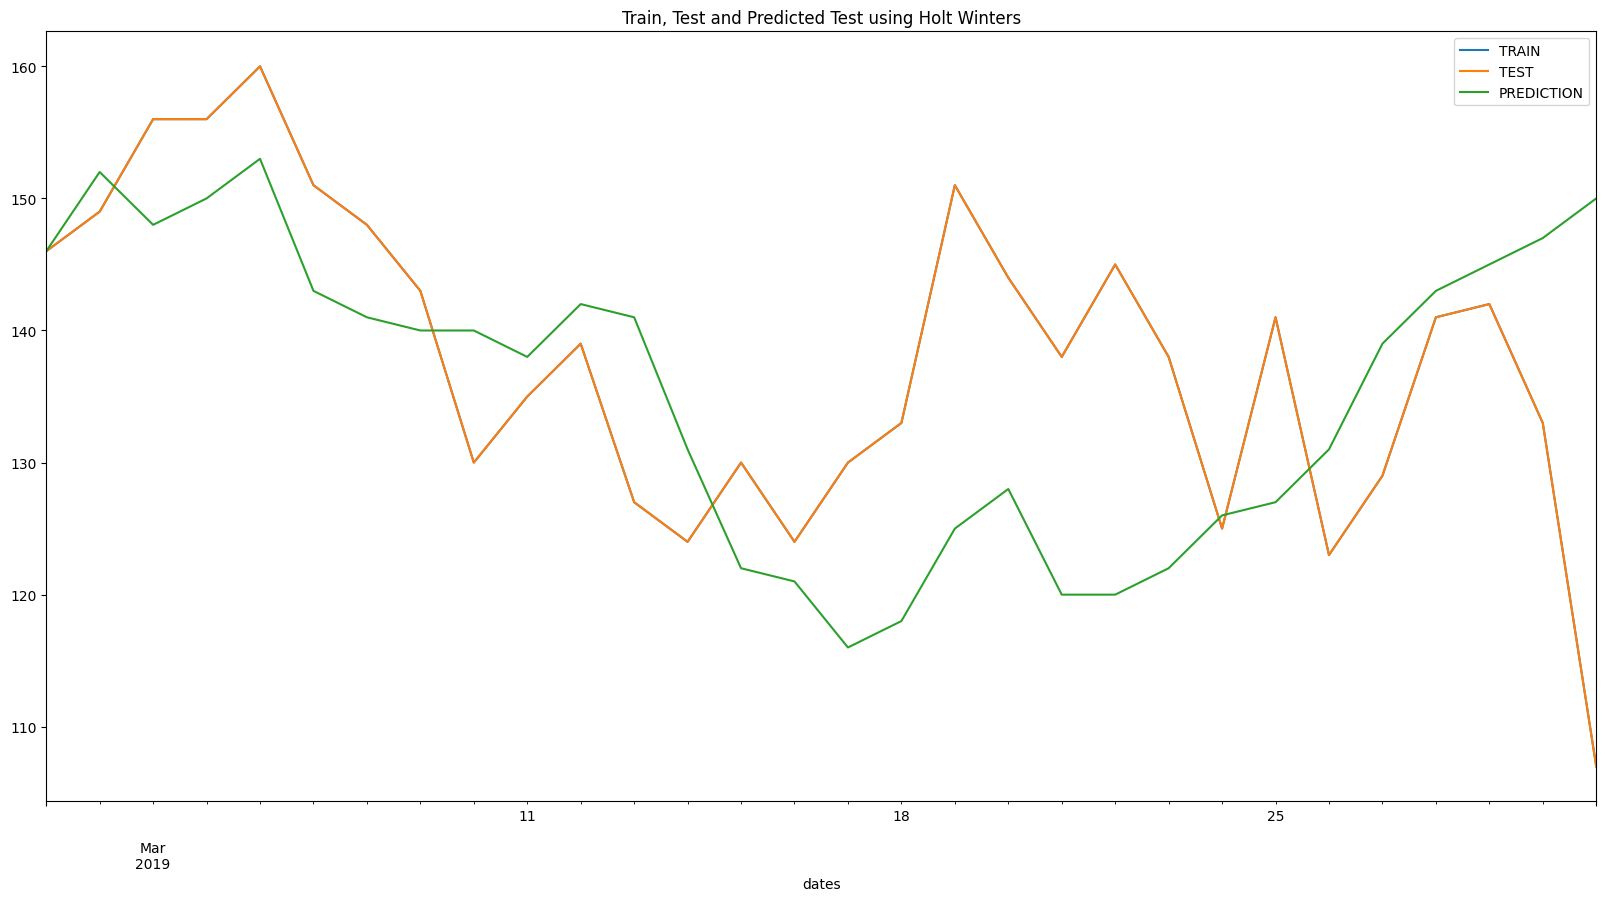

In [115]:
fitted_model = ExponentialSmoothing(train_health['occupancy'],**holt_params).fit()
test_predictions = fitted_model.forecast(target_days)
test_predictions = test_predictions.astype(int)
test_health['occupancy'].plot(legend=True,label='TRAIN')
test_health['occupancy'].plot(legend=True,label='TEST',figsize=(20,10))
test_predictions.plot(legend=True,label='PREDICTION')
plt.title('Train, Test and Predicted Test using Holt Winters')


<Axes: xlabel='dates'>

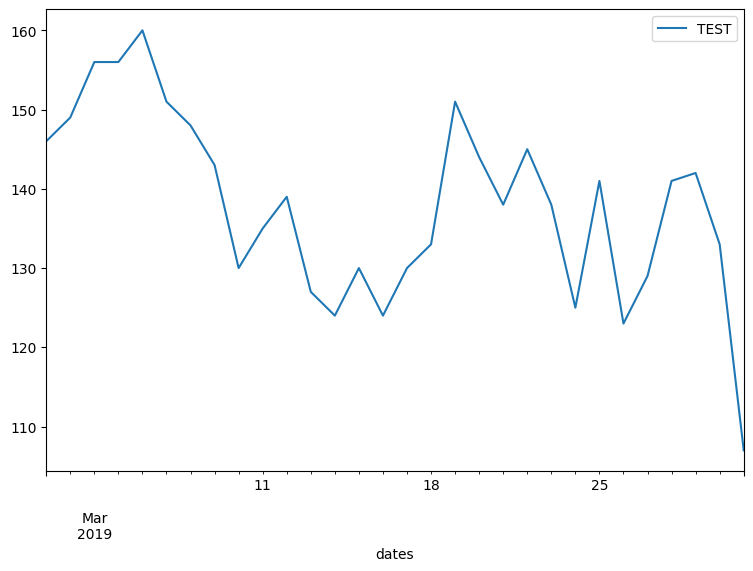

In [116]:
test_health['occupancy'].plot(legend=True,label='TEST',figsize=(9,6))
#test_predictions.plot(legend=True,label='PREDICTION',xlim=['1959–01–01','1961–01–01'])

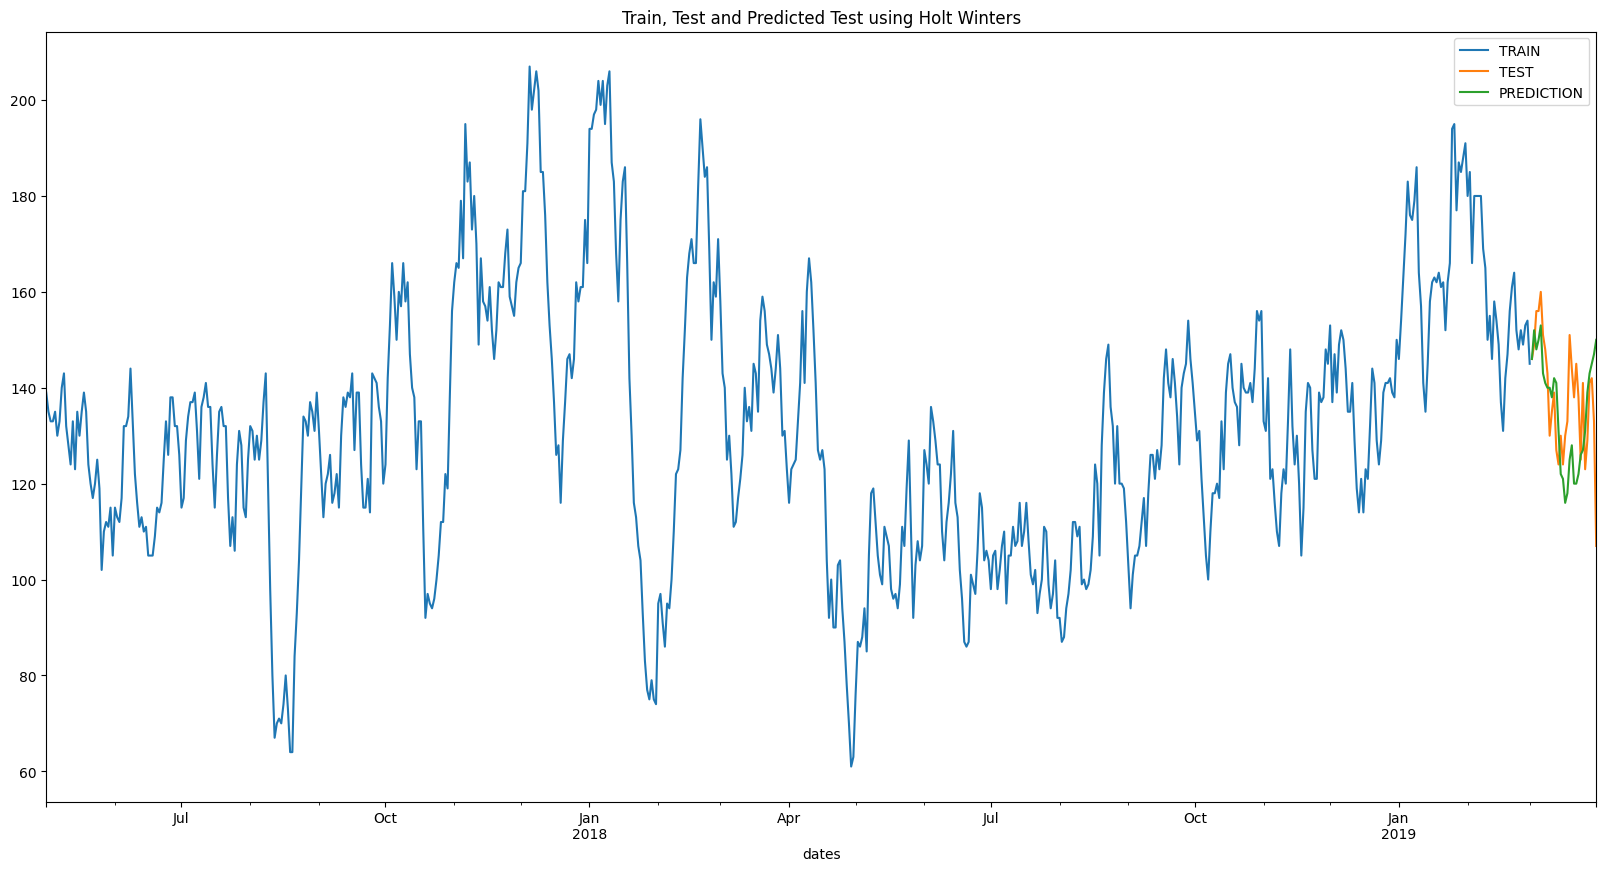

In [117]:
plt.figure(figsize=(20, 10))  # Set the size of the plot

# Plot the training data
train_health['occupancy'].plot(legend=True, label='TRAIN')

# Plot the test data
test_health['occupancy'].plot(legend=True, label='TEST')

# Plot the predicted values
test_predictions.plot(legend=True, label='PREDICTION')

plt.title('Train, Test and Predicted Test using Holt Winters')
plt.show()  # Show the plot

In [118]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
print(f'Mean Absolute Error = {mean_absolute_error(test_health,test_predictions)}')
print(f'Mean Squared Error = {mean_squared_error(test_health,test_predictions)}')
print(f'Root Mean Squared Error = {np.sqrt(mean_squared_error(test_health,test_predictions))}')
print(f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(test_health,test_predictions)}')

Mean Absolute Error = 10.5
Mean Squared Error = 189.76666666666668
Root Mean Squared Error = 13.775582262346179
Mean Absolute Percentage Error = 0.07876292795541827


In [119]:
unix_timestamp = int(time.time())
output_file = (
    '../output/holt_winter/holt-winter-%d.csv' % unix_timestamp
)

In [120]:
#fill the csv with the prediction data
out = (f'target_days: {target_days}\n' )
out = out + "parameters: \n"
for i in holt_params: 
    out = out + (f'{i}: {holt_params[i]}\n')
out = out + (f'Mean Absolute Error = {mean_absolute_error(test_health,test_predictions)}\n')
out = out + (f'Mean Squared Error = {mean_squared_error(test_health,test_predictions)}\n')
out = out + (f'Root Mean Squared Error = {np.sqrt(mean_squared_error(test_health,test_predictions))}\n')
out = out + (f'Mean Absolute Percentage Error = {mean_absolute_percentage_error(test_health,test_predictions)}\n')

out = out + 'dates' + ',' + 'occupancy' + '\n'

for i in range(len(test_predictions)):
    out = out + str((train_health.index[len(train_health)-1] + pd.DateOffset(i)).date()) + ',' + str(test_predictions.iloc[i]) + '\n'

with open(output_file,'w') as f:
    f.write(out)
